## Machine Learning Project - Pneumonia Chest X-Ray Classification Problem

This data was taken from this [kaggle dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810&sortBy=voteCount). 
"For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert."

The two types of pneumonia that appear in the data are viral and bacterial pneumonia, however there is not sufficient differentiation between the two in the dataset, so the objective will be to determine for a given x-ray, is it more likely to be normal or have some form of pneumonia. 

In [1]:
#updating important libraries
pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
#updating important libraries
pip install -Uqq opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
#updating important libraries
pip install -Uqq timm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import fastbook
fastbook.setup_book()

In [5]:
#ML libraries
from fastai.vision.all import *
from fastbook import *
import timm

In [6]:
path = Path('C:/Users/saketm1/Desktop/ML_Projects/Week_3_chest_xray/chest_xray')

In [7]:
#setting up paths for the three sets
train_path = path/'train'
val_path = path/'val'
test_path = path/'test'

In [8]:
train_norms_list = (train_path/'NORMAL').ls().sorted()
train_pneums_list = (train_path/'PNEUMONIA').ls().sorted()

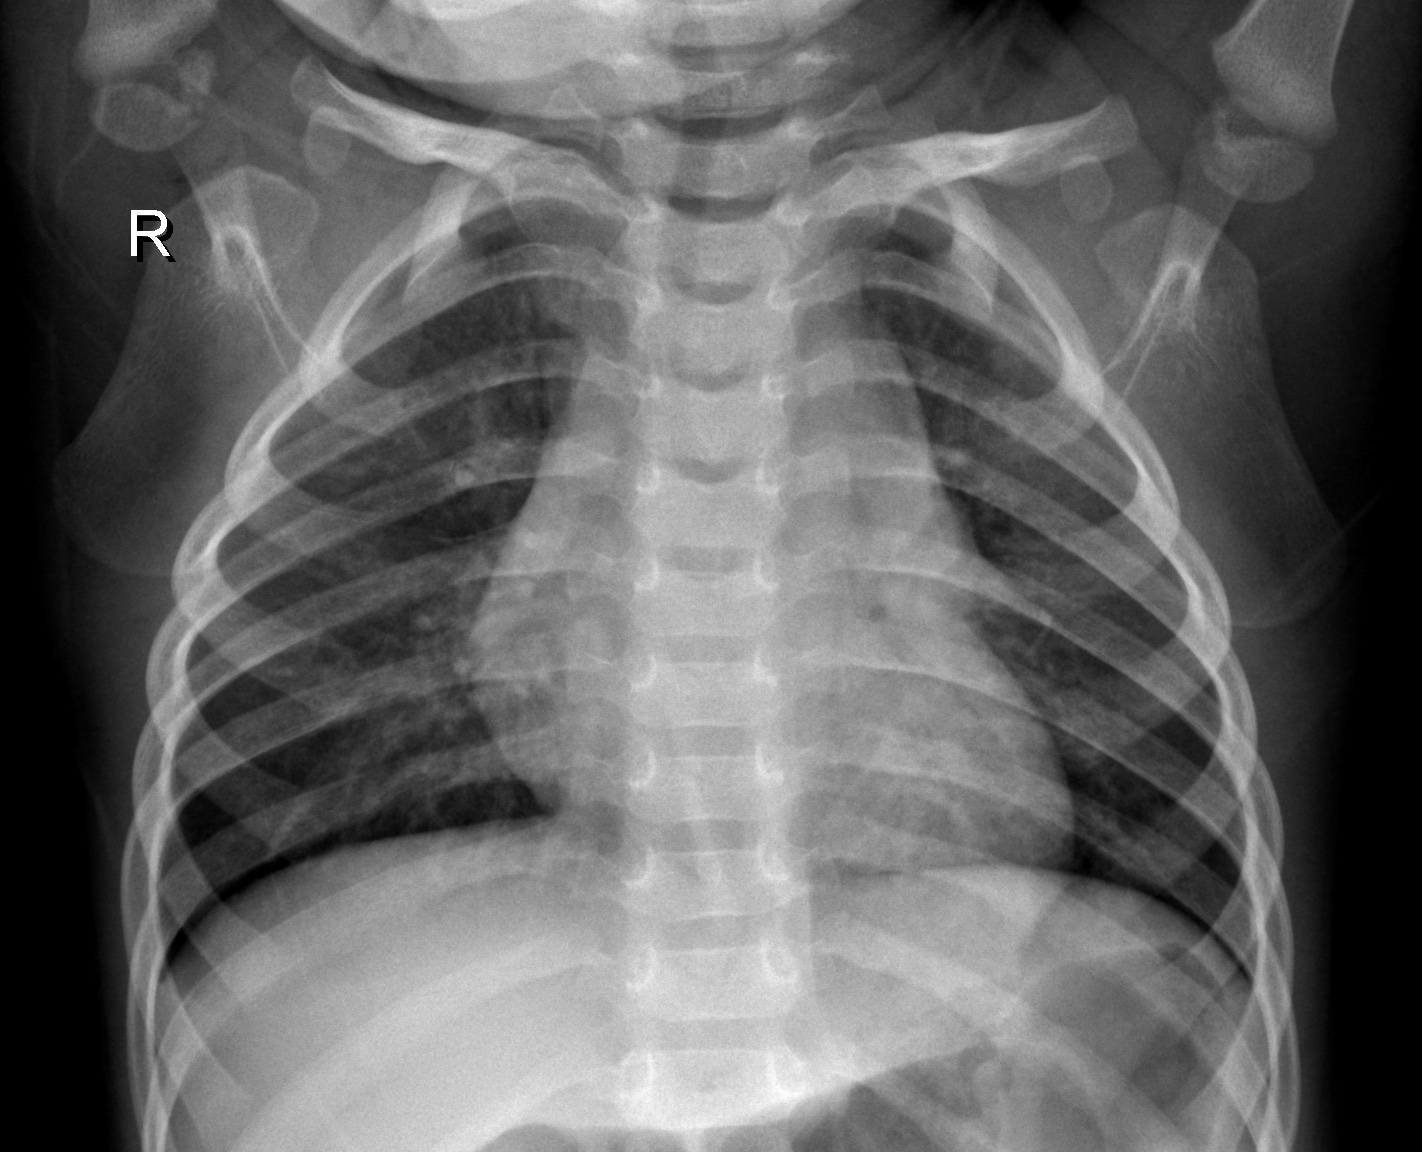

In [10]:
#checking to make sure images open properly and path is correct
check_norms_set = train_norms_list[1]
check_norms = Image.open(check_norms_set)
check_norms

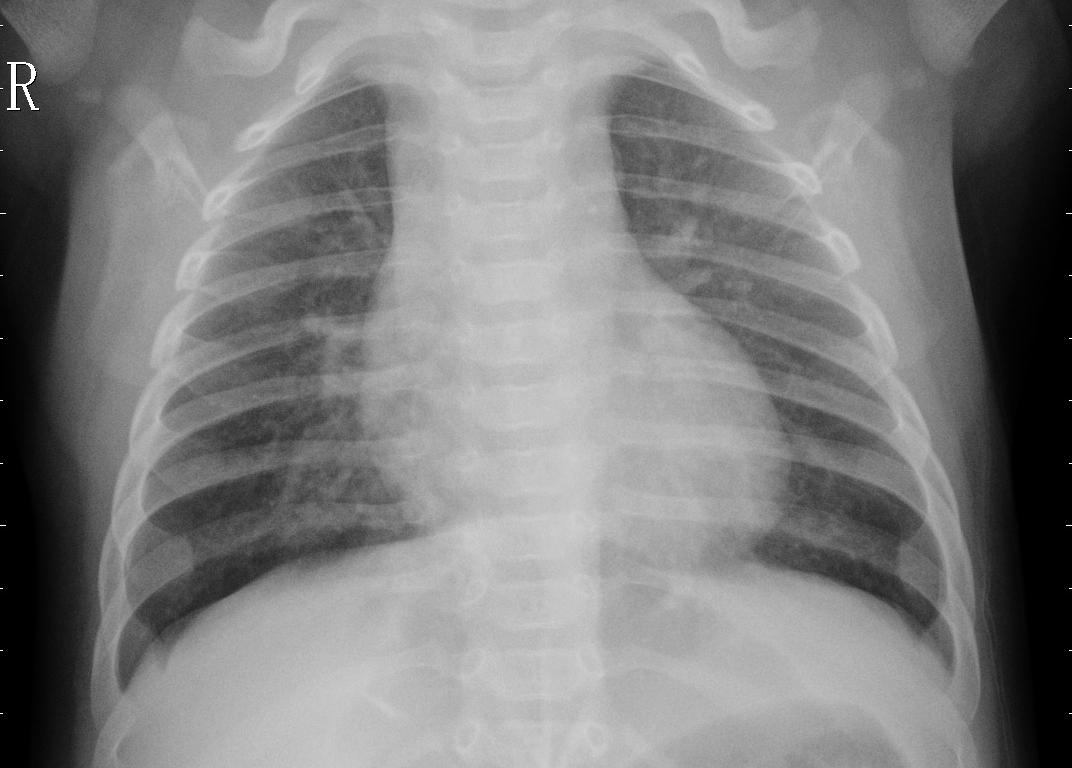

In [11]:
#checking to make sure images open properly and path is correct
check_pneums_set = train_pneums_list[1]
check_pneums = Image.open(check_pneums_set)
check_pneums

In [23]:
#setting up test list
test_norms_list = (test_path/'NORMAL').ls().sorted()
test_pneums_list = (test_path/'PNEUMONIA').ls().sorted()

In [24]:
#combining the pneumonia and normal test lists
test_all_list = test_norms_list + test_pneums_list

In [21]:
#Accuracy of Model on the Test Set
def test_acc(model):
    correct_count = 0
    for i,image in enumerate(test_all_list):
        preds = model.predict(image)
        if i < len(test_norms_list) and preds[0] == 'NORMAL':
            correct_count += 1
        elif i >= len(test_norms_list) and preds[0] == 'PNEUMONIA':
            correct_count += 1
    return correct_count/len(test_all_list)        

## Resnet34 Model

In [12]:
#setting up dataloader for learner object
dls = ImageDataLoaders.from_folder(path,train='train',valid='val',seed=1,item_tfms=Resize(224))

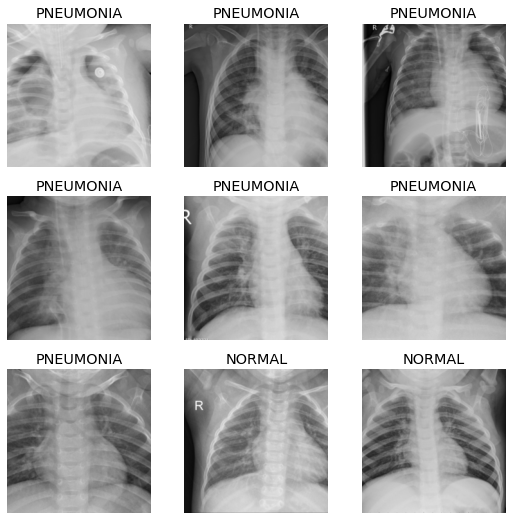

In [13]:
dls.show_batch()

In [16]:
#resnet Model
learn = vision_learner(dls, resnet34, metrics = error_rate)

C:\Users\saketm1\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\saketm1\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0008317637839354575)

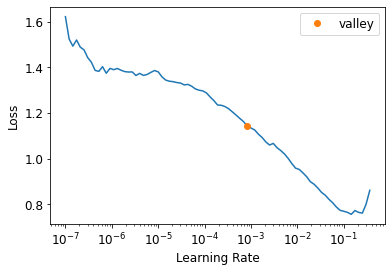

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(1)

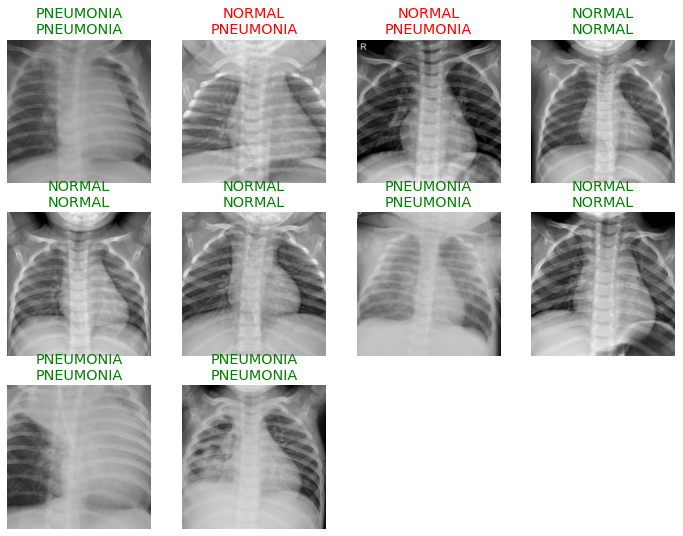

In [22]:
learn.show_results(max_n=10)

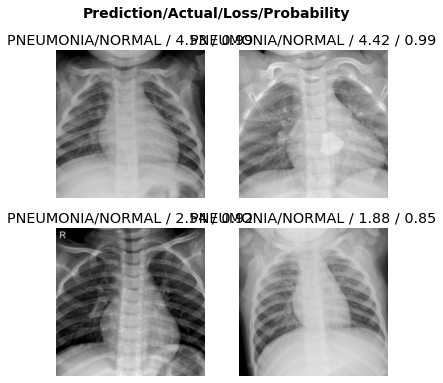

In [24]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(2, nrows = 2)

In [49]:
accuracy = test_acc(learn)
print("Accuracy on the test data using the Resnet34 is:  %.3f%%" %(accuracy*100))

Accuracy on the test data using the Resnet34 is:  83.333%


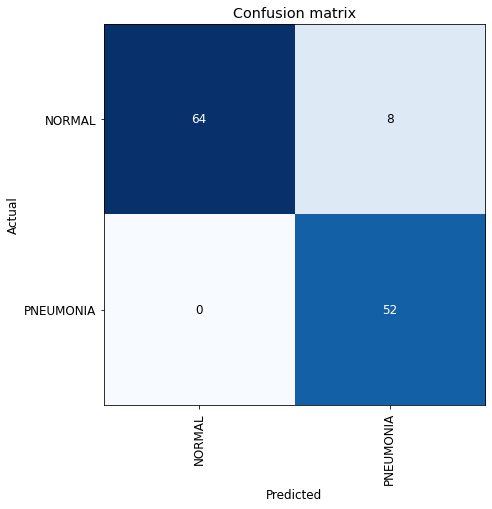

In [32]:
#Confusion matrix of the results from the validation set
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

Sensitivity: 100%
Specificity: 88%

In a medical model, we want to maximize sensitivity because we want to reduce the rate of incorrect negative outcomes because that would provide the patient with a false sense of security and can lead to tremendous legal and persona health implications. This model is successful at doing so, with moderate overall success overall as well. 

## Levit_128 Model

In [34]:
dls2 = ImageDataLoaders.from_folder(path,train='train',valid='val',seed=1
                                    ,item_tfms=Resize(224), batch_tfms = aug_transforms(mult=1))

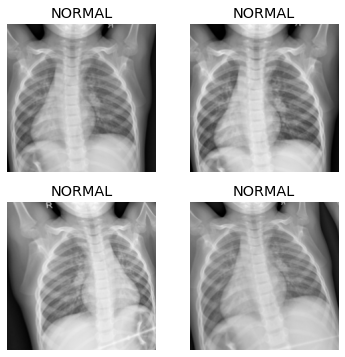

In [36]:
dls2.train.show_batch(max_n=4,nrows=2,unique=True)

In [37]:
timm.list_models('levit*')

['levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_256d',
 'levit_384']

In [41]:
learn2 = vision_learner(dls2, 'levit_128s', metrics = error_rate)

SuggestedLRs(valley=0.0030199517495930195)

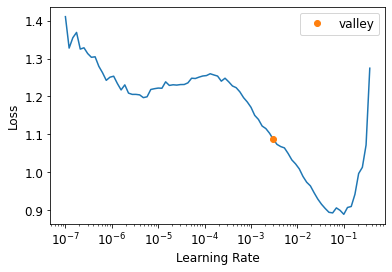

In [42]:
learn2.lr_find()

In [43]:
learn2.fit_one_cycle(1)

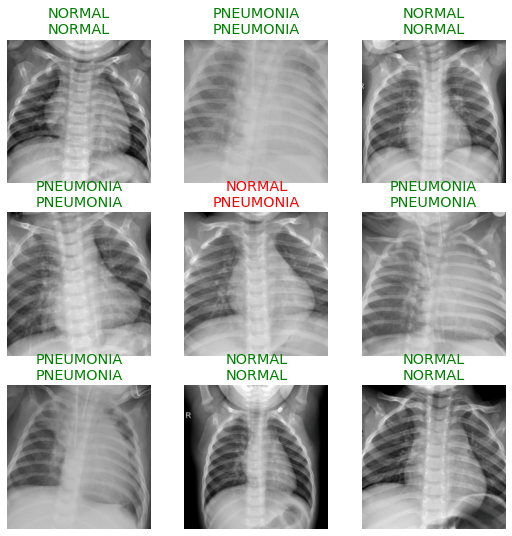

In [45]:
learn2.show_results()

In [46]:
accuracy2 = test_acc(learn2)

In [50]:
print("Accuracy on the test data using the Levit_128 is:  %.3f%%" %(accuracy2*100))

Accuracy on the test data using the Levit_128 is:  78.045%


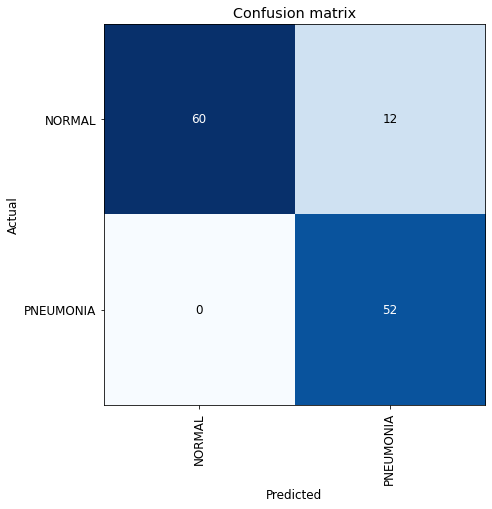

In [52]:
interp2 = ClassificationInterpretation.from_learner(learn2)
losses,idxs = interp2.top_losses()
len(dls2.valid_ds)==len(losses)==len(idxs)
interp2.plot_confusion_matrix(figsize=(7,7))

## Convnext Model

In [53]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [14]:
dls3 = ImageDataLoaders.from_folder(path,train='train',valid='val',seed=1
                                    ,item_tfms=Resize(224), batch_tfms = aug_transforms(mult=2))

In [15]:
learn3 = vision_learner(dls3, 'convnext_base_in22ft1k', metrics = error_rate)

SuggestedLRs(valley=0.0012022644514217973)

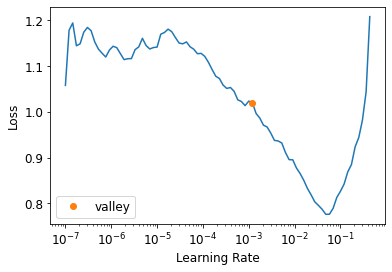

In [16]:
learn3.lr_find()

In [18]:
learn3.fit_one_cycle(1)

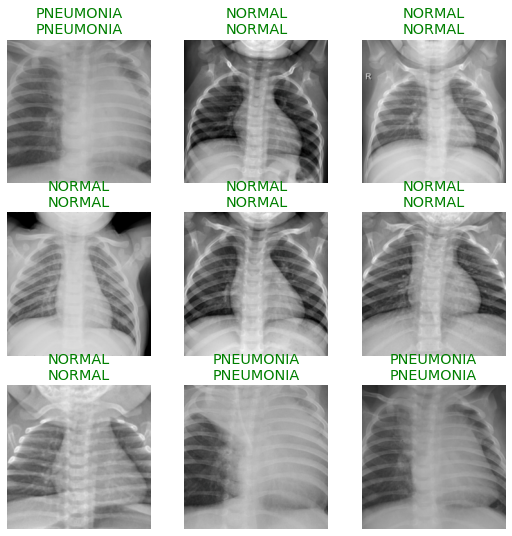

In [19]:
learn3.show_results()

In [25]:
accuracy3 = test_acc(learn3)

In [28]:
print("Accuracy on the test data using the Convnext model is:  %.3f%%" %(accuracy3*100))

Accuracy on the test data using the Convnext model is:  83.974%


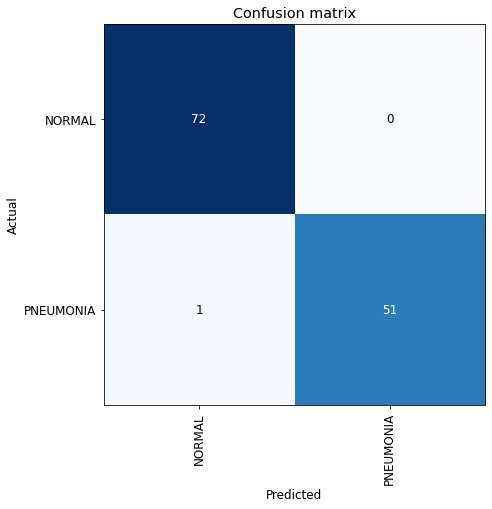

In [29]:
interp3 = ClassificationInterpretation.from_learner(learn3)
losses,idxs = interp3.top_losses()
len(dls3.valid_ds)==len(losses)==len(idxs)
interp3.plot_confusion_matrix(figsize=(7,7))

## Summary

In terms of overall performance, the accuracy was best for the convnext model, then the resnet model, then the levnit model. However, in terms of performance speed: levnit, resnet, convnext model. However, in a scenario such as determining medical diagnoses, for this reason we will proceed with the Convnext model.

In [30]:
final_dl = ImageDataLoaders.from_folder(path,train ='train', valid = 'test', seed = 2,
                                        item_tfms = Resize(224), batch_tfms = aug_transforms(mult=1))

In [31]:
final_learn = vision_learner(final_dl, 'convnext_base_in22ft1k', metrics = error_rate)

SuggestedLRs(valley=0.0014454397605732083)

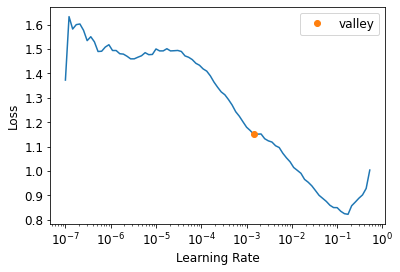

In [32]:
final_learn.lr_find()

In [34]:
final_learn.fit_one_cycle(1)

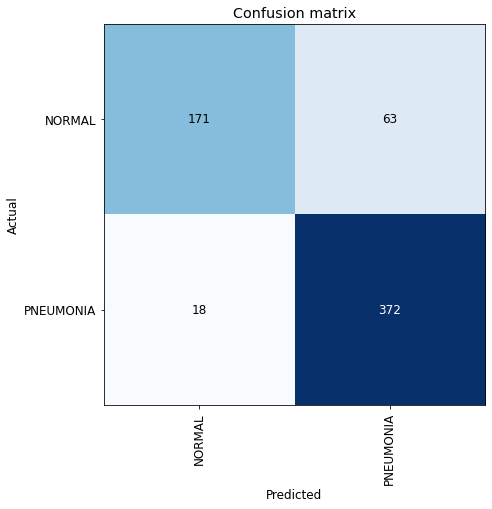

In [35]:
final_interp = ClassificationInterpretation.from_learner(final_learn)
losses,idxs = final_interp.top_losses()
len(final_dl.valid_ds)==len(losses)==len(idxs)
final_interp.plot_confusion_matrix(figsize=(7,7))

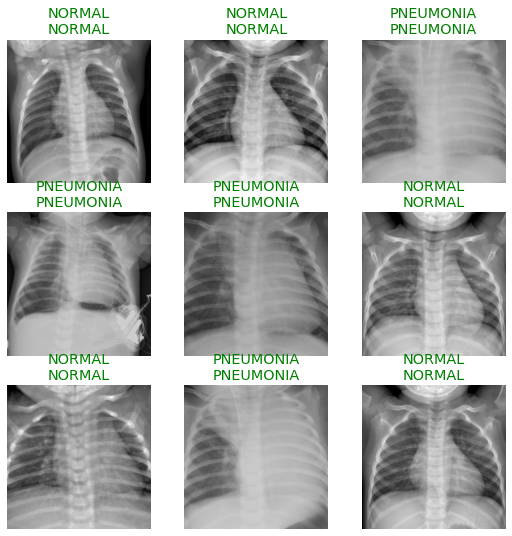

In [36]:
learn3.show_results()